https://github.com/subarnop/Kiddo

Note: must use Tensorflow backend for Keras (this code doesn't work with Theano)

## Initialization

In [0]:
!git clone https://github.com/subarnop/Kiddo.git

Cloning into 'Kiddo'...
remote: Enumerating objects: 67, done.
remote: Total 67 (delta 0), reused 0 (delta 0), pack-reused 67
Unpacking objects: 100% (67/67), done.


In [0]:
classes = ['brain', 'bicycle', 'airplane', 'cat', 'car', 'bird', 'apple', 'bathtub', 'watermelon', 'penguin', 'violin', 'dolphin', 'speedboat', 'cell phone', 'wristwatch', 'peas', 'television', 'skyscraper', 'shoe', 'flower']
# classes = ['brain', 'bicycle', 'cat', 'car', 'bird', 'apple', 'watermelon', 'penguin', 'violin', 'dolphin', 'cell phone', 'wristwatch', 'television', 'skyscraper', 'flower']

In [0]:
%cd /content/Kiddo
!mkdir data
for className in classes:
  !gsutil -q cp "gs://quickdraw_dataset/full/numpy_bitmap/{className}.npy" data/

/content/Kiddo


## Training

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, SeparableConv2D, MaxPooling2D

# Regular convolution
def load_model(input_shape, num_classes, dropout_1_rate=0.25, dropout_2_rate=0.25, dropout_3_rate=0.5):
    model = Sequential()

    model.add(Convolution2D(6, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding="same"))
    model.add(Convolution2D(24, kernel_size=(3, 3), activation='relu'))
    model.add(Convolution2D(12, kernel_size=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_1_rate))

    model.add(Convolution2D(28, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) # added
    model.add(Convolution2D(24, kernel_size=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_2_rate))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(dropout_3_rate))
    model.add(Dense(num_classes, activation='softmax', name="my_output_node"))

    return model


Using TensorFlow backend.


In [0]:
import os
import keras
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from load_data import *
import config

def train_model(dropout_1_rate=0.25, dropout_2_rate=0.25, dropout_3_rate=0.5, lr=1e-3, beta_1=0.9, beta_2=0.999, decay=0.00):
  C = config.Config()

  # epochs      = C.epochs
  epochs = 60
#   batch_size  = C.batch_size
  batch_size = 128
  image_size  = C.image_size

  x_train, y_train, x_test, y_test, class_names = load_data('data')
  num_classes = len(class_names)

  # Reshape and normalize
  x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
  x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')
  input_shape = (image_size, image_size, 1)

  x_train /= 255.0
  x_test /= 255.0

  print('Training data: ', x_train.shape)
  print('Training labels: ', y_train.shape)
  print('Test data: ', x_test.shape)
  print('Test labels: ', y_test.shape)
  print('Class names:', class_names)

  # Not working?
  # plt.figure(figsize=(10, 10))
  # visualize(x_train, y_train, class_names)

  # Convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  # Load model
  model = load_model(input_shape, num_classes, dropout_1_rate, dropout_2_rate, dropout_3_rate)
  
  optimizer = keras.optimizers.Adam(lr, beta_1, beta_2, decay)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  print(model.summary())

  save_filename   = C.save_filename
  callback_period = C.callback_period
#   verbosity       = C.verbosity
  verbosity = 1

  if not os.path.exists(save_filename):
    # Model checkpoint callback
    checkpoint = ModelCheckpoint(
      save_filename,
      monitor='val_acc',
      verbose=verbosity,
      save_best_only=True,
      save_weights_only=False,
      mode='auto',
      period=callback_period)
        
    tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_images=True)

    # Fit the model
    history = model.fit(
      x_train, y_train,
      epochs=epochs, batch_size=batch_size, verbose=verbosity,
      validation_data=(x_test, y_test),
      callbacks=[
          checkpoint,
          tbCallBack
      ])

    # List all data in history
    print(history.history.keys())

    # Plot history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('img/acc.png')
    plt.clf()

    # Plot history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('img/loss.png')
  else:
    # Load previously saved weights and evaluate the model
    model.load_weights(save_filename)
    score, acc = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score)
    print('Test accuracy:', acc)
    
  global global_model
  global_model = model
    
  score, acc = model.evaluate(x_test, y_test, verbose=0)
  return acc
    
# from functools import partial
# train_model_partial = partial(train_model)

Training data:  (160000, 28, 28)
Training labels:  (160000,)
Test data:  (40000, 28, 28)
Test labels:  (40000,)
Class names: ['cat', 'brain', 'wristwatch', 'television', 'violin', 'bathtub', 'peas', 'dolphin', 'bicycle', 'skyscraper', 'watermelon', 'flower', 'speedboat', 'cell phone', 'apple', 'airplane', 'bird', 'shoe', 'penguin', 'car']





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         60        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 24)        1320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 12)        300       
_____________________________________________________

0.8852

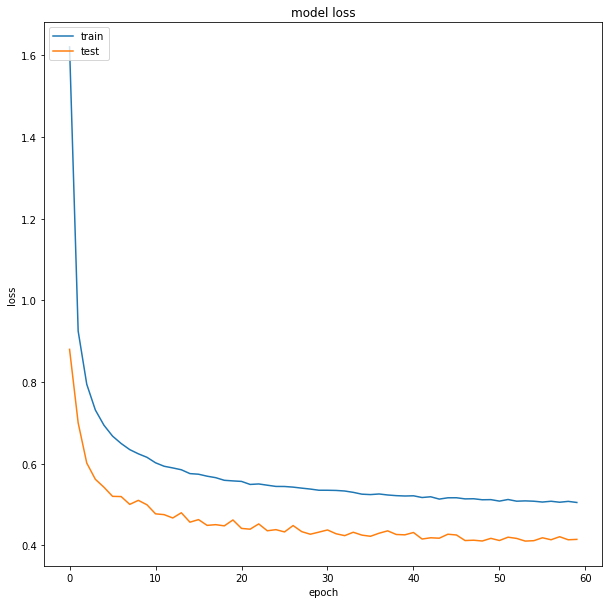

In [0]:
train_model(dropout_1_rate=0.15, dropout_2_rate=0.15, dropout_3_rate=0.15, lr=0.007, beta_1=0.9, beta_2=0.9972, decay=0.03821)

## Run predictions

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
8


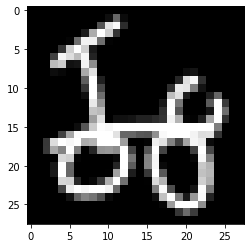

In [0]:
image = x_test[[3]]

plt.imshow(image.reshape(28,28), cmap='gray')
predictions = global_model.predict(image)

print(predictions)
top_class = np.argmax(predictions)
print(top_class)